# Importando dados

importando as bibliotecas que usaremos no ao longo do projeto.

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
# Bibliotecas padrão para manipulação dos dados
import pandas as pd
import numpy as np
import datetime as dt

# Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importando o dataframe
df_original = pd.read_csv('C:/Users/Winicius/Desktop/LightHouse/teste_indicium_precificacao.csv', sep = ',')

In [5]:
# Criando uma cópia para casos de fazer alterações, ainda teremos o principal
df = df_original.copy()

# Análise Explratória dos dados (EDA)

In [6]:
# Visualizando as 5 primeiras colunas para nos familiarizarmos com os dados
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [7]:
# Verificando o tamanho do Dataframe
df.shape

(48894, 16)

In [8]:
# Verificando os tipos das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [9]:
# Verificando a quantidade de valores faltantes
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [10]:
# Verificando a porcentagem dos valores faltantes
(df.isnull().sum()/df.shape[0]*100).round(3)

id                                0.000
nome                              0.033
host_id                           0.000
host_name                         0.043
bairro_group                      0.000
bairro                            0.000
latitude                          0.000
longitude                         0.000
room_type                         0.000
price                             0.000
minimo_noites                     0.000
numero_de_reviews                 0.000
ultima_review                    20.559
reviews_por_mes                  20.559
calculado_host_listings_count     0.000
disponibilidade_365               0.000
dtype: float64

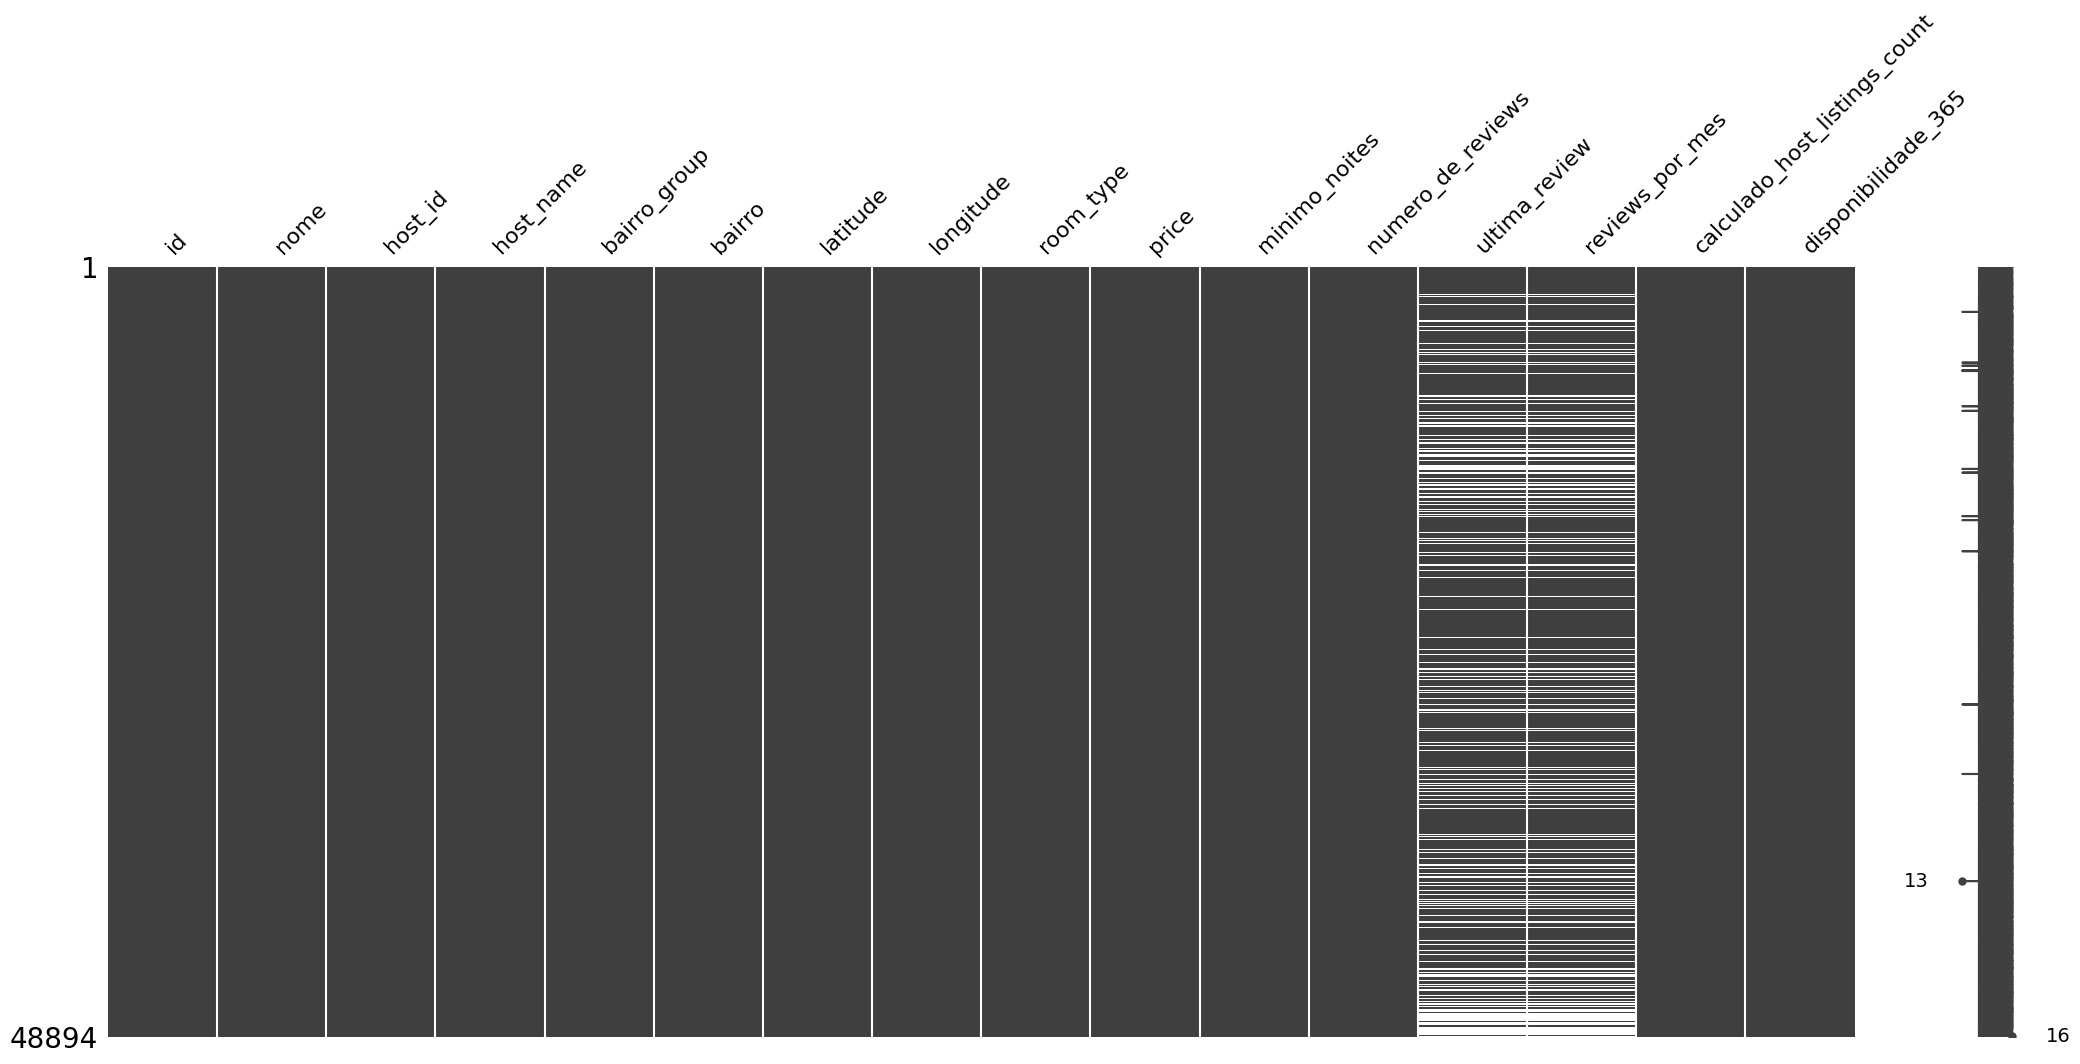

In [11]:
missingno.matrix(df);

Podemos observar que as variáveis última_review e reviews_por_mês são as que têm mais valores ausentes, com aproximadamente 20% em cada uma.

## Analisando os diferentes bairros

In [17]:
# Verificando quantas ocorrências existem em cada variável
df.nome.value_counts()

nome
Hillside Hotel                                        18
Home away from home                                   17
New york Multi-unit building                          16
Brooklyn Apartment                                    12
Loft Suite @ The Box House Hotel                      11
                                                      ..
Feel at Home                                           1
Spacious Modern Alcove Studio in a Luxury Building     1
Artist's Room in Large Apartment                       1
Modern Oasis in Central Park Slope                     1
Trendy duplex in the very heart of Hell's Kitchen      1
Name: count, Length: 47904, dtype: int64

In [16]:
df.bairro.value_counts()

bairro
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Fort Wadsworth           1
Richmondtown             1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: count, Length: 221, dtype: int64

In [15]:
df.bairro_group.value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

Podemos notar que a análise dos grupos de bairros faz mais sentido, pois eles apresentam uma quantidade menor de variáveis a serem analisadas.

In [19]:
df.groupby("bairro_group")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
bairro_group,,,,,,,,
Bronx,1091.0,87.496792,106.709349,0.0,45.0,65.0,99.0,2500.0
Brooklyn,20103.0,124.381983,186.878105,0.0,60.0,90.0,150.0,10000.0
Manhattan,21661.0,196.875814,291.383183,0.0,95.0,150.0,220.0,10000.0
Queens,5666.0,99.517649,167.102155,10.0,50.0,75.0,110.0,10000.0
Staten Island,373.0,114.812332,277.620403,13.0,50.0,75.0,110.0,5000.0


Algumas conclusões:

* O bairro mais caro em média é Manhattan, com um preço médio de 196.88 dólares. O bairro mais barato em média é Bronx, com um preço médio de 87.50 dólares.
* O bairro com maior variação de preços também é Manhattan, com um desvio padrão de 291.38 dólares. Isso significa que os preços dos imóveis nesse bairro são mais dispersos em torno da média. O bairro com menor variação de preços é Bronx, com um desvio padrão de 106.71 dólares. Isso significa que os preços dos imóveis nesse bairro são mais concentrados em torno da média.
* O bairro com maior valor máximo é Manhattan, com um preço máximo de 10.000 dólares. O bairro com menor valor mínimo é Bronx, com um preço mínimo de 0 dólar. Isso pode indicar que há imóveis gratuitos ou muito baratos nesse bairro, ou que há algum erro nos dados (o mais provável).
* O bairro com maior número de locações é Brooklyn, com 20.103. O bairro com menor número de locações é Staten Island, com apenas 373.
* O bairro com maior proporção de locações em relação ao total é Manhattan, com 38.6% das locações. O bairro com menor proporção em relação ao total é Staten Island, com apenas 0.7%.

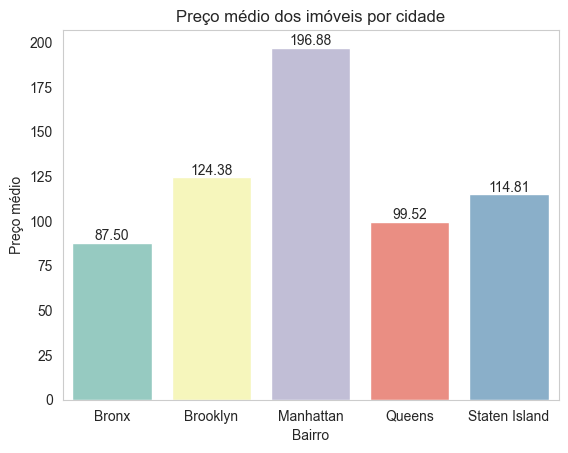

In [76]:
# Agrupar o dataframe por cidade e calcular a média do preço
df_grouped = df.groupby('bairro_group')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Bairro')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por cidade')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:
* O preço médio dos imóveis varia consideravelmente entre os diferentes bairros. Manhattan tem o preço médio mais alto, seguido por Brooklyn, Staten Island, Queens e Bronx.
* O preço médio de Manhattan é mais do que o dobro do preço médio de Bronx, o bairro mais barato. Isso indica uma grande disparidade econômica e social entre os bairros.
* O preço médio de Staten Island é maior do que o de Queens, apesar de ser um bairro mais afastado e menos populoso. Isso pode sugerir uma maior qualidade de vida ou uma menor oferta de imóveis no bairro.
* O preço médio de Brooklyn é próximo do de Staten Island, mas com uma maior variação. Isso pode refletir a diversidade cultural e arquitetônica do bairro, que possui áreas mais nobres e outras mais simples.

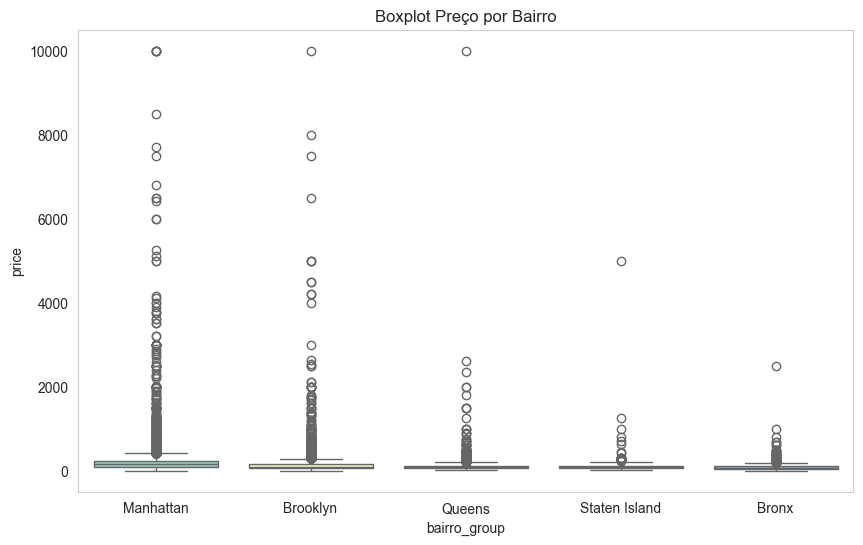

In [61]:
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um boxplot usando seaborn com os dados originais, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y='price', data=df, order=bairros, palette=sns.color_palette("Set3", 5))

# Definir o título do gráfico como 'Boxplot Preço por Bairro'
ax.set_title('Boxplot Preço por Bairro')

# Mostrar o gráfico
plt.show()

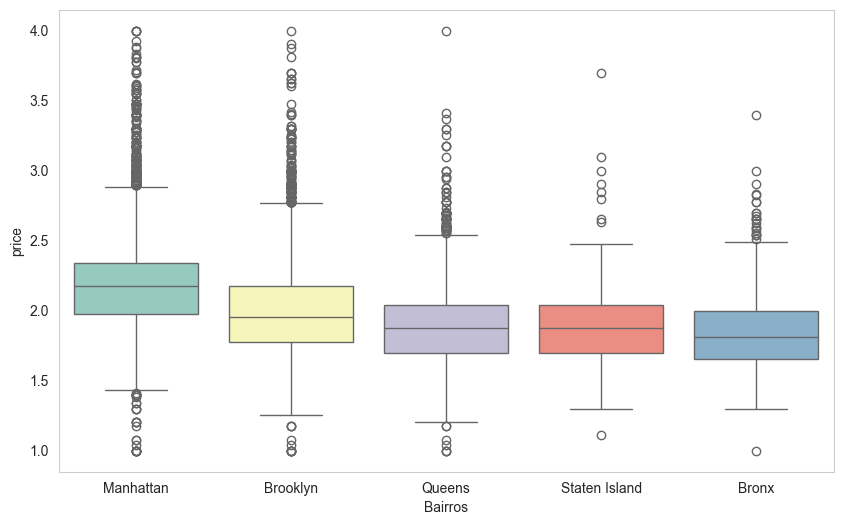

In [60]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize = (10,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y ='price', data = log, order = bairros, palette = sns.color_palette("Set3", 5))

# Definir o rótulo do eixo x como 'Bairros'
ax.set_xlabel('Bairros')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

A partir desses boxplots, podemos concluir que:
* Manhattan tem uma variação de preço significativamente maior e preços mais altos em comparação com os outros bairros. 
* Brooklyn e Queens têm uma variação de preço semelhante, mas Brooklyn tem preços ligeiramente mais altos. 
* Staten Island e Bronx têm a menor variação de preço e os preços mais baixos.

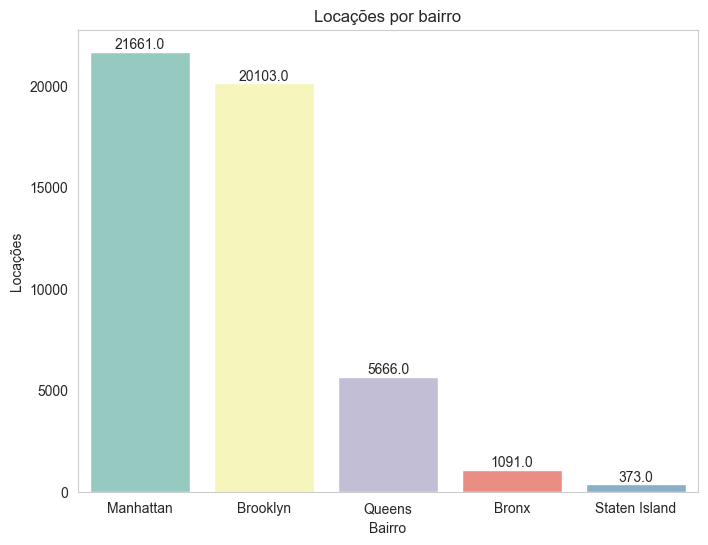

In [64]:
# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='bairro_group', data=df, order= df['bairro_group'].value_counts().index, palette=sns.color_palette("Set3", 5))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Bairro'
ax.set_xlabel('Bairro')

# Definir o rótulo do eixo y como 'Locações'
ax.set_ylabel('Locações')

# Definir o título do gráfico como 'Locações por bairro'
ax.set_title('Locações por bairro')

# Mostrar o gráfico
plt.show()

Como vimos na tabela anterior, a quantidade de locações nos bairros de Manhattan e Brooklyn estão muito acima dos demais bairros.

Conclusões finais:
* Manhattan é o bairro mais desejado e disputado de imóveis em Nova York, mas também o mais caro e instável. Os imóveis nesse bairro podem ter preços exorbitantes ou muito baixos, dependendo da oferta e da procura. Além disso, há uma grande desigualdade social e econômica entre as diferentes áreas de Manhattan.
* Brooklyn e Queens são os bairros mais equilibrados e diversificados em termos de preços e tipos de imóveis em Nova York. Eles oferecem opções mais acessíveis e variadas do que Manhattan, mas também têm áreas mais valorizadas e outras menos. Eles também têm uma maior oferta e demanda de imóveis do que os outros bairros.
* Staten Island e Bronx são os bairros mais baratos e isolados em termos de preços e tipos de imóveis em Nova York. Eles têm pouca oferta e demanda de imóveis, e os preços são mais estáveis e baixos do que nos outros bairros. Eles podem ser uma boa opção para quem busca tranquilidade e economia, mas também podem ter menos infraestrutura e serviços.

## Room Type

In [66]:
df.room_type.value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

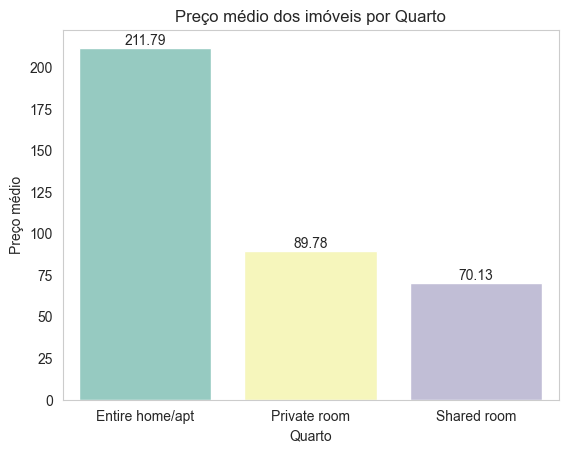

In [77]:
# Agrupar o dataframe por Quarto e calcular a média do preço
df_grouped = df.groupby('room_type')['price'].mean()

# Criar um gráfico de barras usando o seaborn
ax = sns.barplot(x=df_grouped.index, y=df_grouped, palette='Set3')

# Definir os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Quarto')
ax.set_ylabel('Preço médio')
ax.set_title('Preço médio dos imóveis por Quarto')

# Adicionar rótulos nas barras com duas casas decimais
for i in range(len(ax.patches)):
    # Usar o método format para restringir a duas casas decimais
    value = format(ax.patches[i].get_height(), '.2f')
    plt.annotate(value, (ax.patches[i].get_x() + ax.patches[i].get_width() / 2, 
                         ax.patches[i].get_height()), size=10, ha='center', va='bottom')

# Mostrar o gráfico
plt.show()

Algumas conclusões:
* O preço médio dos imóveis varia significativamente dependendo do tipo de quarto. O preço médio é mais alto para um apartamento/casa inteira, seguido por um quarto privado e, finalmente, um quarto compartilhado.
* A diferença de preço entre um apartamento/casa inteira e um quarto privado é de cerca de 122 dolares, o que representa uma variação de aproximadamente 136%. Isso indica que há uma grande demanda por espaços maiores e mais privados na área.
* A diferença de preço entre um quarto privado e um quarto compartilhado é de cerca de 20 dolares, o que representa uma variação de cerca de 22%. Isso sugere que há uma oferta limitada de quartos compartilhados na área, ou que as pessoas preferem pagar um pouco mais por um quarto privado.

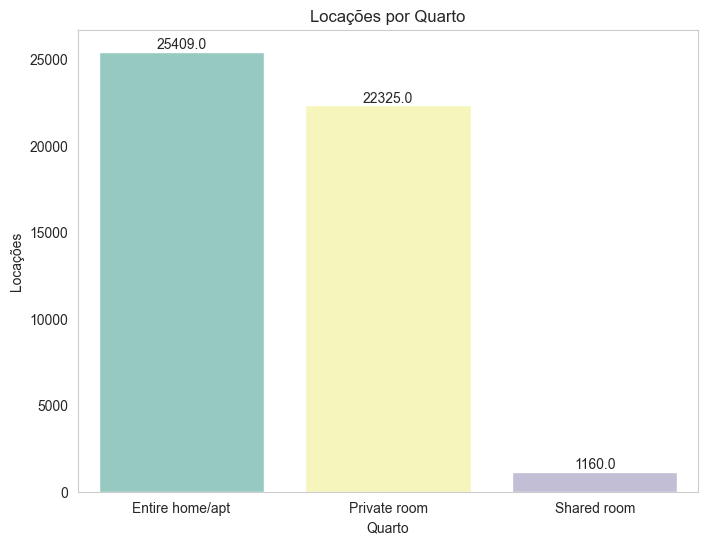

In [68]:
# Criar uma figura com tamanho 8x6
plt.figure(figsize=(8,6))

# Criar um gráfico de barras usando seaborn com os dados do dataframe, ordenando pelo bairro e usando uma paleta de cores
ax=sns.countplot(x='room_type', data=df, order= df['room_type'].value_counts().index, palette=sns.color_palette("Set3"))

# Adicionar rótulos nas barras com o tamanho 10 e alinhados com as bordas
for i in range(len(ax.patches)):
    plt.annotate(str(ax.patches[i].get_height()), (ax.patches[i].get_x() + 
                                                   ax.patches[i].get_width() / 2, 
                                                   ax.patches[i].get_height()), 
                                                   size=10, ha='center', va='bottom')

# Definir o rótulo do eixo x como 'Tipo de quarto'
ax.set_xlabel('Quarto')

# Definir o rótulo do eixo y como 'Locações'
ax.set_ylabel('Locações')

# Definir o título do gráfico como 'Locações por bairro'
ax.set_title('Locações por Quarto')

# Mostrar o gráfico
plt.show()

Algumas conclusões:

* As locações de casas/apartamentos inteiros são mais populares, seguidas por quartos privados e, por último, quartos compartilhados.
* A demanda por quartos compartilhados é muito baixa, representando apenas cerca de 4% do total de locações.
* A diferença entre as locações de casas/apartamentos inteiros e quartos privados é pequena, indicando que ambos os tipos de quarto têm uma demanda semelhante.
* O gráfico pode sugerir que as pessoas preferem ter mais privacidade e conforto ao alugar um espaço, ou que há uma escassez de opções de quartos compartilhados na área.

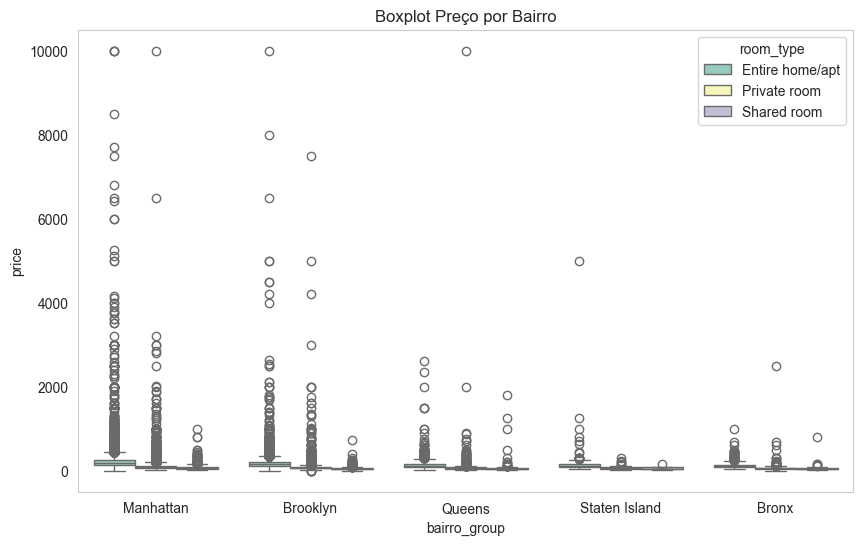

In [78]:
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by=['price'],ascending=False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize=(10,6))

# Criar um boxplot usando seaborn com os dados originais, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y='price', data=df, hue = 'room_type',
                 order=bairros, palette=sns.color_palette("Set3", 5))

# Definir o título do gráfico como 'Boxplot Preço por Bairro'
ax.set_title('Boxplot Preço por Bairro')

# Mostrar o gráfico
plt.show()

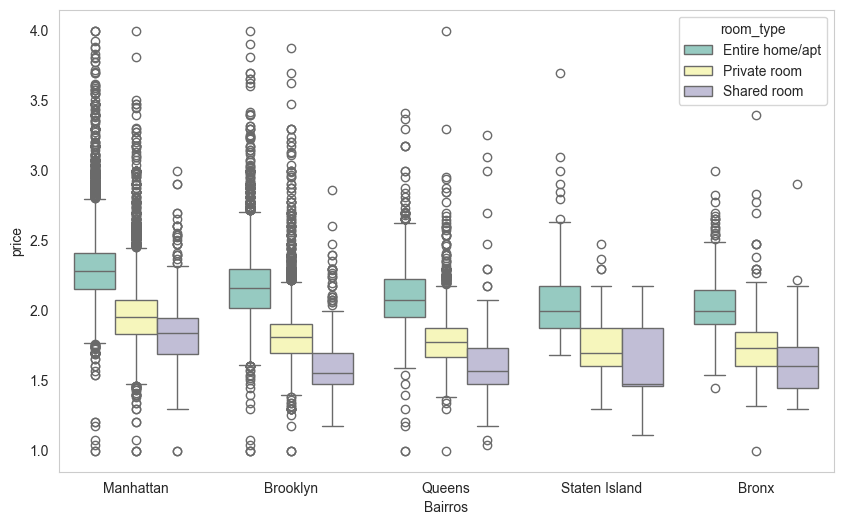

In [80]:
# Gráfico refeito para melhorar a visualização
# Agrupar os dados por bairro e calcular a mediana do preço
bairros = df.groupby('bairro_group').price.median().reset_index().sort_values(by = ['price'],ascending = False)

# Selecionar apenas a coluna do nome do bairro
bairros = bairros['bairro_group']

# Criar uma figura com tamanho 10x6
plt.figure(figsize = (10,6))

# Fazer uma cópia dos dados originais
log = df.copy()

# Aplicar a função logaritmo na base 10 na coluna do preço
log['price'] = log.price.apply(lambda x:np.log10(x))

# Criar um boxplot usando seaborn com os dados transformados, ordenando pelo bairro e usando uma paleta de cores
ax = sns.boxplot(x='bairro_group', y ='price', data = log, 
                 hue = 'room_type',order = bairros, 
                 palette = sns.color_palette("Set3", 5))

# Definir o rótulo do eixo x como 'Bairros'
ax.set_xlabel('Bairros')

# Definir o rótulo do eixo y como 'price'
ax.set_ylabel('price')

# Mostrar o gráfico
plt.show()

Algumas conclusões:
* O preço dos quartos varia consideravelmente dentro de cada bairro e tipo de quarto. Manhattan tem os preços mais altos, especialmente para casas/apartamentos inteiros. Os quartos compartilhados geralmente são mais baratos em todos os bairros.
* Brooklyn e Queens têm uma distribuição semelhante dos preços dos quartos, mas Brooklyn tem mais outliers nos preços mais altos.
* Staten Island e Bronx têm menos dados representados no gráfico, indicando menores listagens disponíveis ou dados coletados.

Conclusões finais:

* Alugar um apartamento/casa inteira em Nova York é uma opção cara e competitiva, que requer uma renda alta e uma boa verificação de crédito. Muitas pessoas optam por essa opção por questões de privacidade, conforto e status.
* Alugar um quarto privado em Nova York é uma opção mais acessível e flexível, que permite economizar dinheiro e conviver com outras pessoas. Muitas pessoas escolhem essa opção por questões de praticidade, conveniência e sociabilidade.
* Alugar um quarto compartilhado em Nova York é uma opção rara e barata, que exige uma adaptação maior e uma tolerância maior. Poucas pessoas preferem essa opção por questões de necessidade, oportunidade ou experiência.
* Os bairros de Nova York têm características diferentes que influenciam nos preços e na disponibilidade dos quartos. Manhattan é o bairro mais caro e disputado, Brooklyn e Queens são os bairros mais diversificados e equilibrados, e Staten Island e Bronx são os bairros mais baratos e isolados.